In [1]:
# Not all of these will be used, remove as needed
import os
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import interact, widgets
import numpy as np
import pandas as pd
from aicsimageio import AICSImage
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.ndimage import binary_dilation
from scipy.signal import butter, filtfilt
from tqdm import tqdm
from skimage import io, filters, morphology
from skimage.util import img_as_ubyte, img_as_float64
from skimage.filters import rank, sobel
from skimage.color import rgb2gray
from skimage.morphology import disk
from skimage.io import imsave
import cv2
from skimage import measure, feature, color
from skimage.draw import disk as draw_disk
import heapq

In [2]:
# List of files for Dan to test
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD 0.5 um_1_2024-01-11_Confocal_01.00.49_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD 0.5 um_2_2024-01-11_Confocal_01.16.28_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD 0.5 um_3_2024-01-11_Confocal_01.08.43_DragonflyUser.ims'

# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/PBP4 1.2OD 0.5 um_1_2024-01-11_Confocal_01.23.49_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/PBP4 1.2OD 0.5 um_2_2024-01-11_Confocal_01.30.50_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/PBP4 1.2OD 0.5 um_3_2024-01-11_Confocal_01.40.34_DragonflyUser.ims'
# '/Users/moose/Downloads/Controls 20240418/PBP4_2024-04-18_Confocal_01.02.30_DragonflyUser.ims'

# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD Nonporous_2024-01-10_Confocal_22.39.44_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD Nonporous 2_2024-01-10_Confocal_22.46.39_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD Nonporous 3_2024-01-11_Confocal_00.32.47_DragonflyUser.ims'
# '/Users/moose/Downloads/Controls 20240418/Nonporous_2024-04-18_Confocal_00.19.10_DragonflyUser.ims'

# Select Datasets
# '/Volumes/SSD/Mike/1.21 OD Device 4_6 Hours_2023-03-15_GFP Staph Aureus_22.39.28_DragonflyUser.ims'
# '/Volumes/SSD/Mike/Od 1.187 Device 1_6 hours_2023-03-03_GFP Staph Aureus_22.24.24_DragonflyUser.ims'
# '/Volumes/SSD/Mike/Od 1.187 Device 2_6 hours_2023-03-03_GFP Staph Aureus_21.44.39_DragonflyUser.ims'


# '/Users/moose/Downloads/Controls 20240418/WT DNase_2024-04-18_Confocal_00.55.19_DragonflyUser.ims'

# '/Users/moose/Downloads/Controls 20240418/WT 1 window_2024-04-18_Confocal_00.33.17_DragonflyUser_FusionStitcher.ims' Do not use!

# '/Users/moose/Downloads/Controls 20240418/WT 1 stack_2024-04-18_Confocal_00.48.57_DragonflyUser.ims' Good test stack for budding events, slightly tilted.

# '/Users/moose/Downloads/Analysis Data Set 06212024/Nonporous_7_2024-06-21_Confocal_00.49.44_DragonflyUser.ims'
# '/Users/moose/Downloads/Analysis Data Set 06212024/Nonporous_8_2024-06-21_Confocal_00.51.14_DragonflyUser.ims'
# '/Users/moose/Downloads/Analysis Data Set 06212024/DNase_1_2024-06-20_Confocal_23.51.58_DragonflyUser.ims'
# '/Users/moose/Downloads/Analysis Data Set 06212024/PBP4_5_2024-06-21_Confocal_00.25.15_DragonflyUser.ims'

In [3]:
# Load raw ims file here

file_name = '/Users/moose/Downloads/Analysis Data Set 06212024/Nonporous_7_2024-06-21_Confocal_00.49.44_DragonflyUser.ims'
image = AICSImage(file_name)
image_data = image.get_image_data("ZYX", S=0, T=0, C=0)

SLF4J: No SLF4J providers were found.
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See https://www.slf4j.org/codes.html#noProviders for further details.


In [4]:
# Global variables
key_frame = '/Users/moose/Desktop/trace_ca-local/key-frame-ca-norm2.tif'
key_img = io.imread(key_frame)
norm_flat = key_img # Need to fix in code for clarity, this variable is redundant.

# Some of these are not used, remove later
DoG_thresh = 0.3
lowerbound = 2
search_mod = 25
z_project = 10
bloom_mod = 1

BlurToggle = False
gkernal = (21, 21)

DilateToggle = False
dstructure = np.ones((3, 3))

In [5]:
def otsu_subtract(gray_img, rad=50):
    img_variance = np.var(gray_img)  # Find overall variance
    img_sigma = np.sqrt(img_variance) # Find standard deviation
    smooth_img = filters.gaussian(gray_img, sigma=img_sigma) # Use standard deviation as sigma for Gaussian blur. Probably not the best method but it works.

    # Sliding otsu to preserve dot morphology. This is a simple approach.
    ubyte_img = img_as_ubyte(smooth_img) # Pixel scaling to 8-bit, needed to run sliding otsu or else it throws an error.
    local_otsu = rank.otsu(ubyte_img, disk(rad)) # Sliding otsu.
    mask_test = ubyte_img >= local_otsu*1.1 # 1.1 is a fudge factor to make the mask a bit bigger, also removes nonsense output.
    # Makes a mask that uses disk radii around local detections. Probably won't work on dense cluster images but works on this example.

    masked_img = np.where(mask_test, gray_img, 0) # Apply mask on grayscale image, set all non-masked pixels to 0.

    return masked_img

In [6]:
# All functions
def subtractflatfield(input_img):
    grayscale_img = input_img
    poly2d_fcn = lambda xy, a, b, c, d, e, f: a + b*xy[0] + c*xy[1] + d*xy[0]*xy[0] + e*xy[1]*xy[1] + f*xy[0]*xy[1]

    y, x = np.indices(grayscale_img.shape)

    x_co = x.flatten()
    y_co = y.flatten()
    pix_val = grayscale_img.flatten()

    p0 = [1, 1, 1, 1, 1, 1]
    popt, _ = curve_fit(poly2d_fcn, (x_co, y_co), pix_val, p0=p0) 
    flat_field_img = poly2d_fcn((x_co, y_co), *popt).reshape(grayscale_img.shape)
    fit_img = grayscale_img - (flat_field_img)

    return fit_img

def background_subtract(img_dat):
    x1 = np.min(img_dat)
    x2 = []
    for i in range(len(img_dat)):
        x2.append(img_dat[i] - x1)

    x2 = np.maximum(x2, 0)

    return x2

def means_match(input_img, kfimg):
        # kfmod = subtractflatfield(kfimg)
        # kfmod = kfmod-np.min(kfmod)
        kfmod = kfimg
        kfmean = np.mean(kfmod)

        # xmod_loss = []

        best_mean_diff = np.inf
        best_xmod = 0
        mean_diff = 0
        bftest = input_img
        bfmin = np.min(bftest)
            
        for xmod in tqdm(np.linspace(0.01, 10, 500), desc='Means Matching'):
            xmodtest = np.clip(xmod * (bftest), np.min(kfimg), np.max(kfimg))
            mean_xmodtest = np.mean(xmodtest)
            mean_diff = abs(mean_xmodtest - kfmean)

            # xmod_loss = mean_diff # Diagnostic
                
            if mean_diff < best_mean_diff:
                best_mean_diff = mean_diff
                best_xmod = xmod

            if mean_diff < 0.0005:
                print(f'Image is at an acceptable target, stopping iterations')
                break

            bfimg = np.clip(best_xmod * (input_img - np.min(input_img)), np.min(kfimg), np.max(kfimg))

        return bfimg, kfmod, best_xmod

In [7]:
flattened_im_data = []
for i in tqdm(range(len(image_data)), desc='Removing background from stack'):
    flattened_im_data.append(subtractflatfield(image_data[i]))

Removing background from stack: 100%|██████████| 41/41 [00:16<00:00,  2.51it/s]


In [8]:
# Initial image processing
frame_mean = []
frame_min = []
frame_max = []
frame_std = []
frame_95 = []
frame_05 = []
for i in range(len(image_data)):
    frame_mean.append(np.mean(image_data[i]))
    frame_min.append(np.min(image_data[i]))
    frame_max.append(np.max(image_data[i]))
    frame_std.append(np.std(image_data[i]))
    frame_95.append(np.percentile(image_data[i], 95))
    frame_05.append(np.percentile(image_data[i], 5))

plusband = []
minusband = []
for i in range(len(image_data)):
    plusband.append(frame_mean[i] + frame_std[i])
    minusband.append(frame_mean[i] - frame_std[i])

frame_mean_top = []
frame_mean_bottom = []
for i in range(len(image_data)//2):
    frame_mean_bottom.append(frame_mean[i])

for i in range(len(image_data)//2, len(image_data)):
    frame_mean_top.append(frame_mean[i])

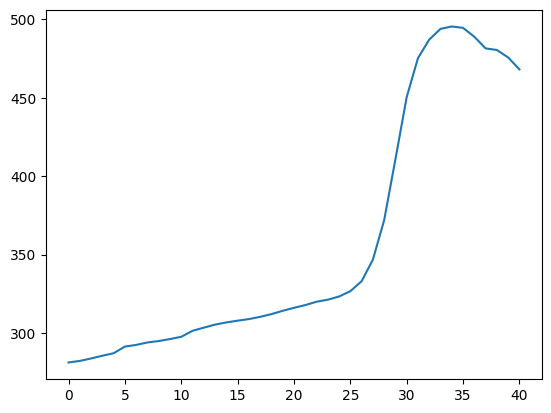

In [9]:
plt.plot(frame_mean, label='Mean')

In [10]:
# Peak detection
background_collect = background_subtract(frame_mean)
peaks2, _ = find_peaks(background_collect, height = 1)

if len(peaks2) == 0:
    max_key = {}
    for i in range(len(background_collect)):
        max_key[i] = background_collect[i]
    true_max = max(max_key.keys())
    peaks2 = [true_max]

if len(peaks2) > 1:
    print('Multiple peaks detected, selecting the highest peak')
    max_key = {}
    for i in range(len(background_collect)):
        max_key[i] = background_collect[i]
    true_max = max(max_key.keys())
    peaks2 = [true_max]

print(peaks2)

[34]


In [11]:
# Generate ensemble model for focus measure voting
hist_key = {}

for i in range(peaks2[0]-search_mod, peaks2[0]):
    if i > 0:
        hist_key[i] = image_data[i]

for i in range(peaks2[0], peaks2[0]+search_mod+1):
    if i < len(image_data):
        hist_key[i] = image_data[i]

hist_stdev = {}
for i in hist_key.keys():
    hist_stdev[i] = np.std(hist_key[i])

hist_laplace = {}
hist_laplace_focusemeasure = {}
for i in hist_key.keys():
    hist_laplace[i] = cv2.Laplacian(hist_key[i], cv2.CV_64F)
    hist_laplace_focusemeasure[i] = np.var(hist_laplace[i])

hist_tenengrad_focusemeasure = {}
hist_squared_grad = {}
for i in hist_key.keys():
    sobelx = cv2.Sobel(hist_key[i], cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(hist_key[i], cv2.CV_64F, 0, 1, ksize=5)

    magnitude = np.sqrt(sobelx**2 + sobely**2)
    squared_grad = (sobelx**2 + sobely**2)

    hist_tenengrad_focusemeasure[i] = np.var(magnitude)
    hist_squared_grad[i] = np.var(squared_grad)


hist_brenner_focusemeasure = {}
for i in hist_key.keys():
    shifted_right = np.roll(hist_key[i], -1, axis=1)
    shifted_down = np.roll(hist_key[i], -1, axis=0)

    diff_right = (shifted_right - hist_key[i])[:-1, :-1] ** 2
    diff_down = (shifted_down - hist_key[i])[:-1, :-1] ** 2

    sum_diff = np.sum(diff_right) + np.sum(diff_down)
    hist_brenner_focusemeasure[i] = sum_diff

hist_max = {}
for i in hist_key.keys():
    hist_max[i] = np.max(hist_key[i])

In [12]:
# Finalize vote

weight_mat = [1, 1, 1, 1, 1, 1]
focus_margins = []

# stdev_two_largest = heapq.nlargest(2, hist_stdev.values())
# laplace_two_largest = heapq.nlargest(2, hist_laplace_focusemeasure.values())
# tenengrad_two_largest = heapq.nlargest(2, hist_tenengrad_focusemeasure.values())

stdev_stdev = np.std(list(hist_stdev.values()))
laplace_stdev = np.std(list(hist_laplace_focusemeasure.values()))
tenengrad_stdev = np.std(list(hist_tenengrad_focusemeasure.values()))
squared_grad_stdev = np.std(list(hist_squared_grad.values()))
brenner_stdev = np.std(list(hist_brenner_focusemeasure.values()))


weight_mat[0] = stdev_stdev/np.mean(list(hist_stdev.values()))
weight_mat[1] = laplace_stdev/np.mean(list(hist_laplace_focusemeasure.values()))
weight_mat[2] = tenengrad_stdev/np.mean(list(hist_tenengrad_focusemeasure.values()))
weight_mat[3] = squared_grad_stdev/np.mean(list(hist_squared_grad.values()))
weight_mat[4] = brenner_stdev/np.mean(list(hist_brenner_focusemeasure.values()))

focus_ensemble = []
focus_ensemble.append(max(hist_stdev, key=hist_stdev.get))
focus_ensemble.append(max(hist_laplace_focusemeasure, key=hist_laplace_focusemeasure.get))
focus_ensemble.append(max(hist_tenengrad_focusemeasure, key=hist_tenengrad_focusemeasure.get))
focus_ensemble.append(max(hist_squared_grad, key=hist_squared_grad.get))
focus_ensemble.append(max(hist_brenner_focusemeasure, key=hist_brenner_focusemeasure.get))

voting_power = []
for i in range(len(focus_ensemble)):
    voting_power.append((focus_ensemble[i], weight_mat[i]))

vote = {}
for frame_num, weighted_vote in voting_power:
    if frame_num in vote:
        vote[frame_num] += weighted_vote

    else:
        vote[frame_num] = weighted_vote

print(f'Final Vote - Membrane Layer at:  ' + str(max(vote, key=vote.get)))
mem_layer = max(vote, key=vote.get)

Final Vote - Membrane Layer at:  30


In [13]:
# for i in range(len(flattened_im_data)):
#     qte = (flattened_im_data[i] - np.min(flattened_im_data[i]))/(np.max(flattened_im_data[i]) - np.min(flattened_im_data[i]))
#     flattened_im_data[i] = img_as_ubyte(qte)

In [14]:
# Create z-projection

bud_test = []
for i in range(z_project):
    bud_test.append(mem_layer-i-bloom_mod)

bud_test_img = []
for i in bud_test:
    bud_test_img.append(flattened_im_data[i])

bud_composite = np.max(bud_test_img, axis=0)

bud_img = bud_composite

In [15]:
# import numpy as np
# from scipy.ndimage import gaussian_filter
# from skimage.feature import peak_local_max

# image_3d = image_data
# smoothed_image = gaussian_filter(image_3d, sigma=5)
# coordinates = peak_local_max(image_3d, min_distance=10)

# print(coordinates)

In [16]:
# import numpy as np
# import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# # Assuming `image_3d` is your 3D image and `coordinates` contains the (z, y, x) positions of the detected peaks

# # # Step 1: Plot the 3D image (downsampled for visualization)
# z, y, x = np.nonzero(image_3d[::200, ::200, ::200])  # Downsample for plotting
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(x, y, z, c='blue', marker='.', alpha=0.1)  # Plot with low alpha to see through

# # Step 2: Overlay detected peaks
# peak_z, peak_y, peak_x = coordinates.T
# ax.scatter(peak_x, peak_y, peak_z, c='red', marker='o')  # Peaks in red

# # Step 3: Enhance visualization
# ax.set_xlabel('X Axis')
# ax.set_ylabel('Y Axis')
# ax.set_zlabel('Z Axis')
# plt.title('3D Image with Detected Peaks')
# plt.show()

In [17]:
# len(coordinates)

In [18]:
# Process z-projection and normalize brightness.
# bud_norm = (bud_img - np.min(bud_img)) / (np.max(bud_img) - np.min(bud_img))
# bud_norm = img_as_ubyte(bud_norm)


bud_sub = bud_img
bud_sub = (bud_sub - np.min(bud_sub)) / (np.max(bud_sub) - np.min(bud_sub))
bud_sub = img_as_ubyte(bud_sub)  


bud_matched, kf_fin, xtest = means_match(bud_sub, norm_flat)

Means Matching: 100%|██████████| 500/500 [00:03<00:00, 148.72it/s]


In [19]:
xtest

2.2922845691382765

In [20]:
# bud_matched = (bud_matched - np.min(bud_matched)) / (np.max(bud_matched) - np.min(bud_matched))
# bud_matched = img_as_ubyte(bud_matched)

In [21]:
# plt.imshow(cv2.medianBlur(bud_matched, 3), cmap='gray')

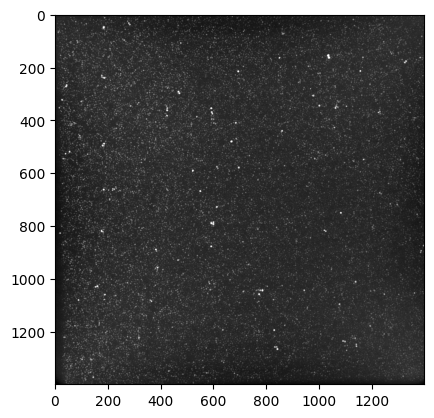

In [22]:
plt.imshow(bud_matched, cmap='gray')

In [23]:
# blurred = cv2.medianBlur(bud_matched, 3)
# adap_thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 11, 2)
# structuring_element = morphology.disk(3)
# opened = morphology.binary_opening(adap_thresh, structuring_element)
# closed = morphology.binary_closing(opened, structuring_element)
# plt.imshow(closed, cmap='gray')

In [24]:
np.mean(bud_matched)

77.67519271798696

In [25]:
np.mean(bud_matched)*2.5

194.1879817949674

In [26]:
np.percentile(bud_matched, 99.5)

148.99849699398797

(array([0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 1.43000e+02, 0.00000e+00,
        0.00000e+00, 1.32000e+02, 0.00000e+00, 3.75000e+02, 0.00000e+00,
        1.06200e+03, 0.00000e+00, 0.00000e+00, 2.31700e+03, 0.00000e+00,
        4.49500e+03, 0.00000e+00, 8.21600e+03, 0.00000e+00, 0.00000e+00,
        1.42530e+04, 0.00000e+00, 2.29970e+04, 0.00000e+00, 3.62180e+04,
        0.00000e+00, 5.70670e+04, 0.00000e+00, 0.00000e+00, 8.97920e+04,
        0.00000e+00, 1.32116e+05, 0.00000e+00, 1.77

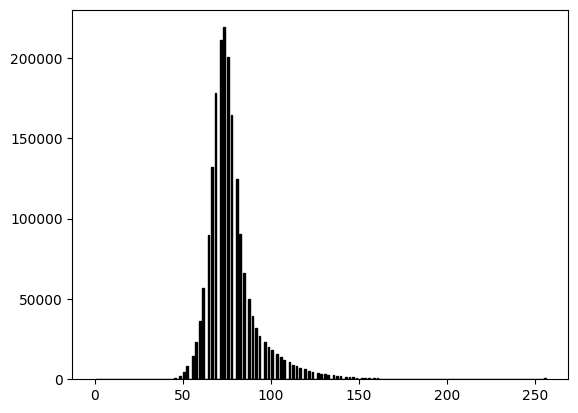

In [27]:
plt.hist(bud_matched.flatten(), bins=256, range=(0, 256), fc='k', ec='k')

In [61]:
# Image processing for budding events
# Threshold image
bud_thresh = np.percentile(bud_matched, 98)
bud_brightest = np.where(bud_matched > bud_thresh, 255, 0)

# plt.figure(dpi=300)
# plt.imshow(bud_brightest, cmap='gray')
# plt.axis('off')
# # plt.savefig('/Users/moose/Desktop/trace_ca-local/' + os.path.splitext(os.path.basename(file_name))[0] + '_binary.tif', dpi=500)
# plt.show()

# Morphological analysis
closed_im = morphology.closing(bud_brightest, morphology.square(1))
label_im = measure.label(closed_im)
region_im = measure.regionprops(label_im, intensity_image=bud_matched)
# for part in region_im:
#     print('Label: {} Area: {}'.format(part.label, part.area))

# area_list = []
# for part in region_im:
#     area_list.append(part.area)

# delete_small_components = filters.threshold_otsu(np.array(area_list)) 
# area_list = [part for part in area_list if delete_small_components < part < 10000]

# intensity_list = []
# for part in region_im:
#     intensity_list.append(part.mean_intensity)

# int_cut = np.percentile(intensity_list, 50)
# intensity_list = [part for part in intensity_list if  int_cut < part]

# eccentricity_list = []
# for part in region_im:
#     eccentricity_list.append(part.eccentricity)

# eccentricity_list = [part for part in eccentricity_list if 0.05 < part < 0.99]

# area_list_thresh = np.percentile(area_list, 98)
# mean_comp = np.percentile(intensity_list, 98)
# std_mean_comp = np.std([part for part in intensity_list if part > mean_comp])
# mean_comp = np.percentile(norm_flat, 99.8)
# lower_ecc = np.percentile(eccentricity_list, 2)
# higher_ecc = np.percentile(eccentricity_list, 98)

# filter_area_low = area_list_thresh 
# filter_eccentricity_low = lower_ecc
# filter_eccentricity_high = higher_ecc
# region_im_filtered = [part for part in region_im if part.mean_intensity > mean_comp]
# region_im_filtered = [part for part in region_im_filtered if filter_area_low < part.area < 10000]
# region_im_filtered = [part for part in region_im_filtered if filter_eccentricity_low < part.eccentricity < filter_eccentricity_high]

region_im_filtered = [
                      part for part in region_im 
                    #   if part.intensity_mean > np.max([mean_comp, 135])
                    #   and np.max([filter_area_low, 15]) < part.area < 10000 
                    #   and filter_eccentricity_low < part.eccentricity < filter_eccentricity_high
                      if part.intensity_max > 250
                      and part.intensity_mean - part.intensity_min > np.percentile(bud_matched, 5)
                      and part.intensity_min < np.mean(bud_matched)+3*np.std(bud_matched)-1 # Necessarty fudge factor to prevent false positives
                      ]

print('Raw Regions: {}'.format(len(region_im)))
print('Filtered Regions: {}'.format(len(region_im_filtered)))

Raw Regions: 7520
Filtered Regions: 0


In [62]:
for part in region_im_filtered:
      print('Centroid: ({:.0f}, {:.0f}) | '
            'Area: {} | '
            'Eccentricity {:.2f} | '
            'Min Intensity {:.2f} |'
            'Mean Intensity {:.2f} | '
            'Max Intensity {:.2f}'.format(part.centroid[0], 
                                          part.centroid[1], 
                                          part.area, 
                                          part.eccentricity,
                                          part.intensity_min, 
                                          part.intensity_mean, 
                                          part.intensity_max))

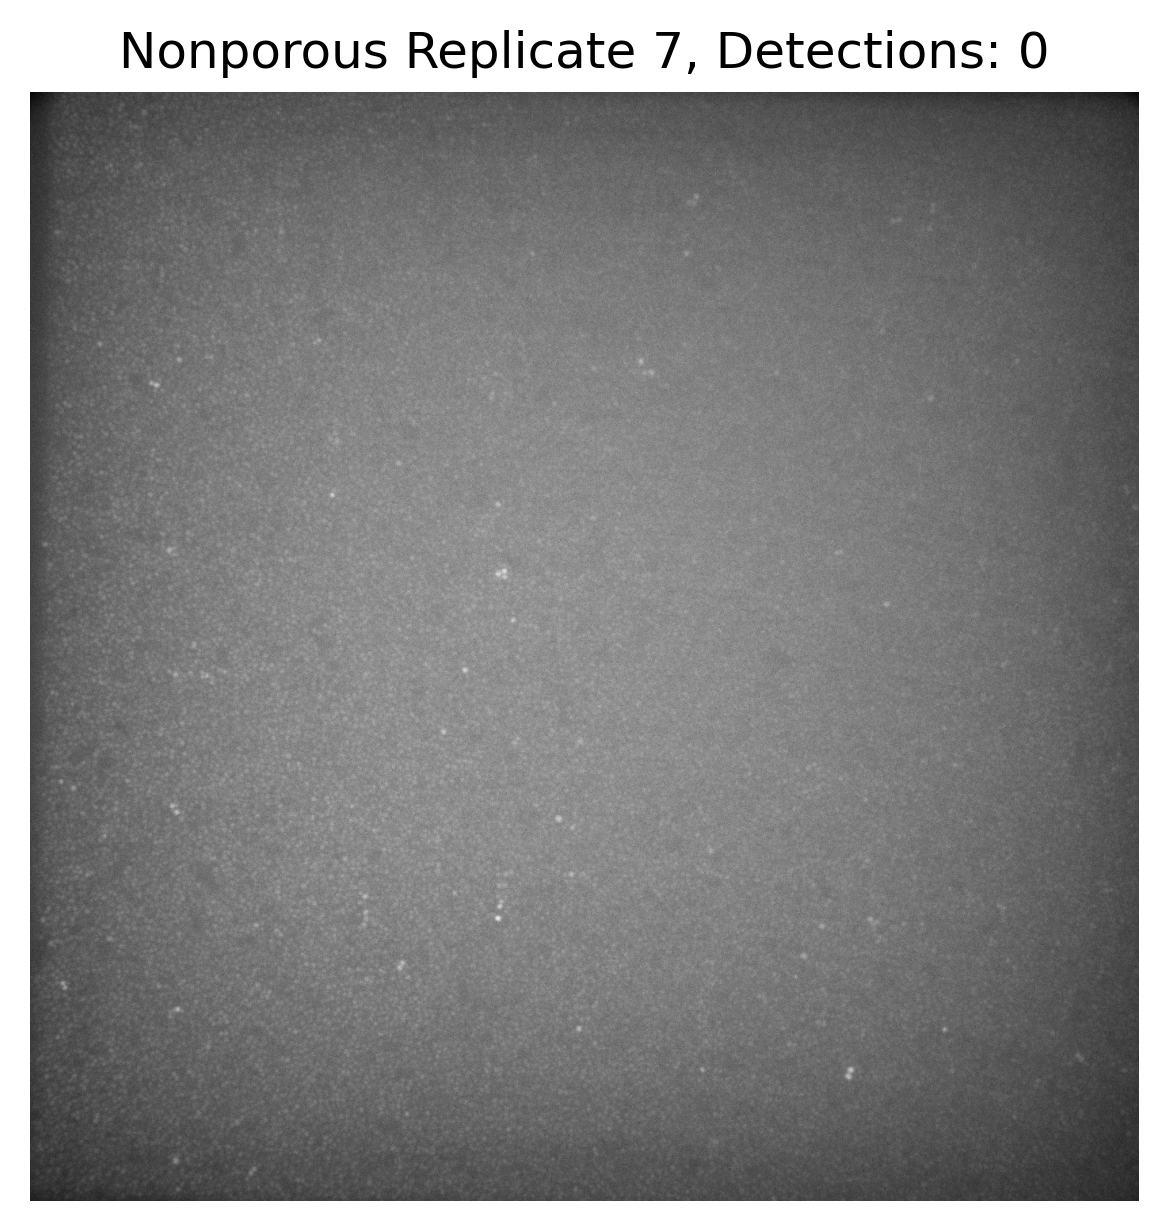

In [63]:
fig_alt, ax_alt = plt.subplots(dpi=300)
ax_alt.imshow(image_data[mem_layer-3], cmap='gray')
for region in region_im_filtered:
    y, x = region.centroid
    radius = np.sqrt(region.area / np.pi)

    circle = plt.Circle((x, y), np.where(radius*5 < 15, radius*5, 15), fill=False, edgecolor='red')
    ax_alt.add_patch(circle)
   
ax_alt.invert_yaxis()
plt.axis('off')
plt.title(os.path.basename(file_name).split('_')[0] 
          + ' Replicate ' 
          + os.path.basename(file_name).split('_')[1] 
          + ', ' 
          + 'Detections: ' 
          + str(len(region_im_filtered)) )
plt.show()

In [31]:
voting_block = []
voting_block.append('STDEV')
voting_block.append('LAPLACE')
voting_block.append('TENENGRAD')
voting_block.append('SQUARED_GRAD')
voting_block.append('BRENNER')
vote_stats = []
for i in range(len(voting_power)):
    vote_stats.append([])

for i in range(len(vote_stats)):
    vote_stats[i] = (voting_block[i], voting_power[i])

In [32]:
for i in range(len(voting_power)):
    print(f'{voting_power[i][0]}, {voting_power[i][1]}')

31, 0.20892234440842208
32, 0.3136720008929986
30, 1.3830640255981366
30, 2.1311026042156755
31, 0.4812907269087357


In [33]:
vote

{31: 0.6902130713171578, 32: 0.3136720008929986, 30: 3.514166629813812}

In [34]:
dfCoords = pd.DataFrame(columns=['Centroid X', 'Centroid Y', 'Area', 'Eccentricity', 'Min Intensity', 'Mean Intensity', 'Max Intensity'])
for part in region_im_filtered:
    dfCoords = dfCoords._append({'Centroid X': part.centroid[0], 
        'Centroid Y': part.centroid[1], 
        'Area': part.area, 
        'Eccentricity': part.eccentricity,
        'Min Intensity': part.intensity_min,
        'Mean Intensity': part.mean_intensity, 
        'Max Intensity': part.intensity_max}, ignore_index=True)

/var/folders/p0/tb_jc0zs6z383snrfzw6d5_00000gn/T/ipykernel_80004/587429739.py:3: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfCoords = dfCoords._append({'Centroid X': part.centroid[0],


In [35]:
dfCoords

,Centroid X,Centroid Y,Area,Eccentricity,Min Intensity,Mean Intensity,Max Intensity
0,51.355769,183.961538,104.0,0.749435,123.783367,195.941763,255.0
1,160.325000,1034.750000,160.0,0.838732,123.783367,227.585209,255.0
2,180.494382,1325.550562,89.0,0.852708,123.783367,190.432162,255.0
3,215.071429,1155.000000,42.0,0.409368,123.783367,208.740450,255.0
4,271.329268,42.621951,82.0,0.825443,123.783367,213.406387,255.0
5,296.427184,468.330097,103.0,0.842864,123.783367,210.250409,255.0
6,345.982143,999.642857,56.0,0.486491,123.783367,191.496375,255.0
7,360.071429,423.938776,98.0,0.897689,123.783367,197.133073,255.0
8,356.153846,590.807692,52.0,0.585735,123.783367,218.177488,255.0
9,373.517241,593.643678,87.0,0.853861,123.783367,204.693016,255.0


In [36]:
masks = []
for prop in region_im_filtered:
    masks.append(prop.intensity_image)

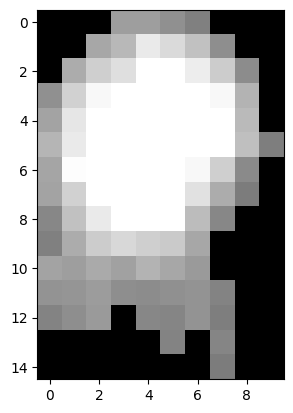

In [37]:
if len(masks) > 0:
    plt.imshow(masks[0], cmap='gray')

In [38]:
# # Need to use cv2.imwrite or else some small images will get corrupted! (Saved as 1-line RGB image? Weird)
# for i in range(len(masks)):
#     masks[i] = np.array(masks[i], dtype=np.uint8)
#     cv2.imwrite('/Users/moose/Desktop/trace_ca-local/LogRegImages/True/' + os.path.splitext(os.path.basename(file_name))[0] + '_mask_' + str(i) + '.tif', masks[i])

In [39]:
boundingbox = []
for prop in region_im_filtered:
    boundingbox.append(prop.bbox)

allboxes = []
for i in range(len(boundingbox)):
    diffb = [abs(boundingbox[i][2] - boundingbox[i][0]), abs(boundingbox[i][3] - boundingbox[i][1])]
    allboxes.append(diffb)

In [40]:
if len(allboxes) > 0:
    max(max(allboxes))

In [41]:
bounded_stack = []
for i in range(len(region_im_filtered)):
    bounded_stack.append([])

for i in range(len(region_im_filtered)):
    min_row, min_col, max_row, max_col = region_im_filtered[i].bbox
    for j in range(mem_layer-5, mem_layer):
        sub_image = image_data[j][min_row:max_row, min_col:max_col]
        bounded_stack[i].append(sub_image)

In [42]:
# stack_check = 1

# fig, axs = plt.subplots(1, len(bounded_stack[stack_check]), figsize=(25, 5)) 

# for i in range(len(bounded_stack[stack_check])):
#     axs[i].imshow(bounded_stack[stack_check][i], cmap='gray')  
#     axs[i].axis('off') 

# plt.tight_layout() 
# plt.show() 

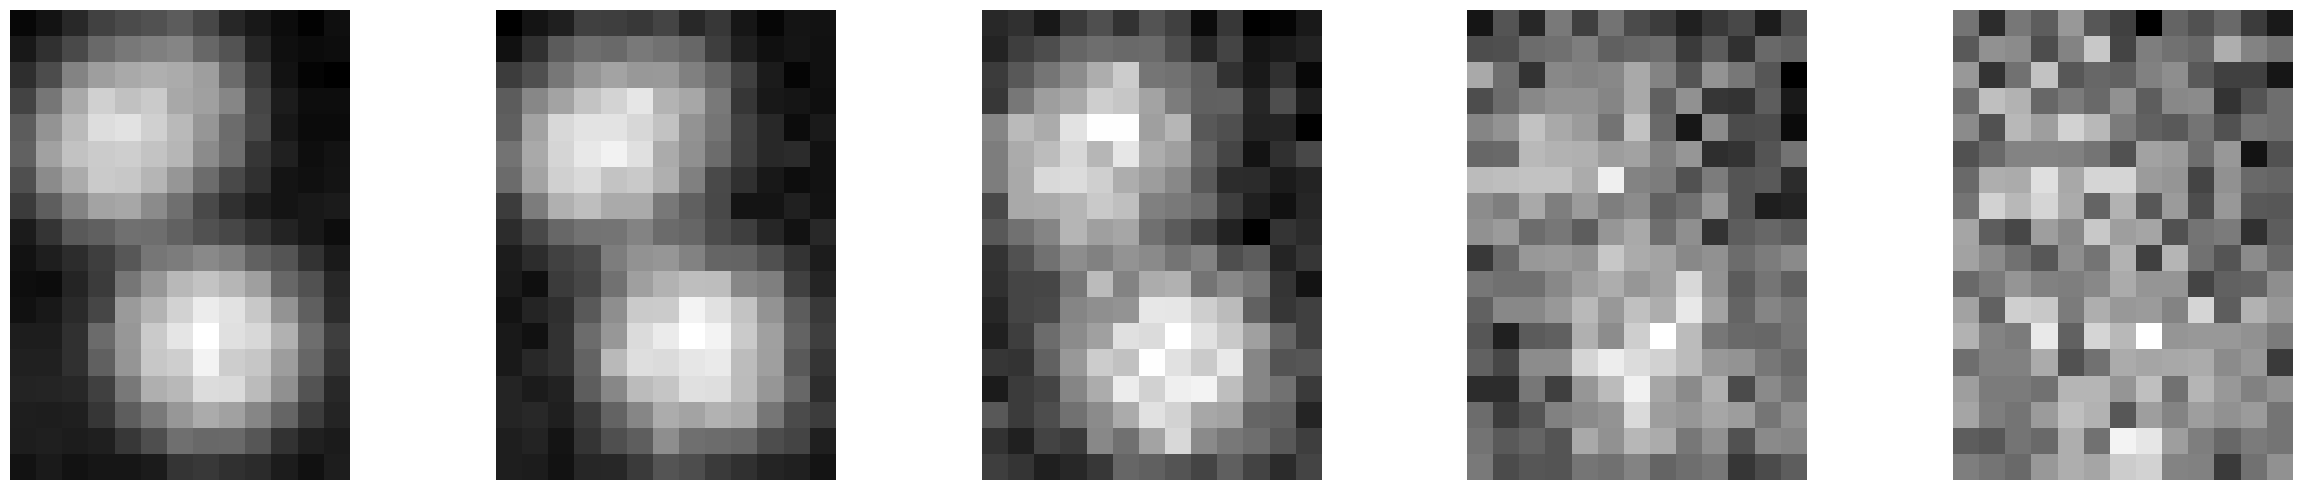

In [43]:
if len(bounded_stack) > 0:   
    stack_check = 1

    fig, axs = plt.subplots(1, len(bounded_stack[stack_check]), figsize=(25, 5)) 

    # Iterate in reverse order
    for i in range(len(bounded_stack[stack_check])-1, -1, -1):
        axs[len(bounded_stack[stack_check])-1-i].imshow(bounded_stack[stack_check][i], cmap='gray')  
        axs[len(bounded_stack[stack_check])-1-i].axis('off') 

    plt.tight_layout() 
    plt.show()

In [44]:
def edge_density(image):
    edges = sobel(image)
    return edges.mean()

In [45]:
edge_stack = []
for i in range(len(bounded_stack)):
    edge_stack.append([])

for i in range(len(bounded_stack)):
    for j in range(len(bounded_stack[i])):
        edge_stack[i].append(edge_density(bounded_stack[i][j]))
    edge_stack[i] = edge_stack[i][::-1]

In [46]:
tennengrad_stack = []
for i in range(len(bounded_stack)):
    tennengrad_stack.append([])

for i in range(len(bounded_stack)):
    for j in range(len(bounded_stack[i])):
        sobelx = cv2.Sobel(bounded_stack[i][j], cv2.CV_64F, 1, 0, ksize=5)
        sobely = cv2.Sobel(bounded_stack[i][j], cv2.CV_64F, 0, 1, ksize=5)

        magnitude = np.sqrt(sobelx**2 + sobely**2)
        tennengrad_stack[i].append(np.var(magnitude))
    tennengrad_stack[i] = tennengrad_stack[i][::-1]

In [47]:
mean_intensity_stack = []
for i in range(len(bounded_stack)):
    mean_intensity_stack.append([])

for i in range(len(bounded_stack)):
    for j in range(len(bounded_stack[i])):
        mean_intensity_stack[i].append(np.mean(bounded_stack[i][j]))
    mean_intensity_stack[i] = mean_intensity_stack[i][::-1]

In [48]:
bud = 0
nbud = 0
for i in range(len(tennengrad_stack)):
    if abs(tennengrad_stack[i][1] - tennengrad_stack[i][0])/(tennengrad_stack[i][0]) < 0.60:
        bud += 1
    else:
        nbud += 1
print(f'Tennengrad: Budding events: {bud}, Non-budding events: {nbud}')

Tennengrad: Budding events: 1, Non-budding events: 21


In [49]:
bud = 0
nbud = 0
for i in range(len(mean_intensity_stack)):
    if abs(mean_intensity_stack[i][1] - mean_intensity_stack[i][0])/(mean_intensity_stack[i][0]) < 0.10:
        bud += 1
    else:
        nbud += 1
print(f'Mean Intensity: Budding events: {bud}, Non-budding events: {nbud}')

Mean Intensity: Budding events: 0, Non-budding events: 22


In [50]:
bud = 0
nbud = 0
for i in range(len(mean_intensity_stack)):
    if abs(mean_intensity_stack[i][0]) > 1.5*np.mean(image_data[mem_layer]):
        bud += 1
    else:
        nbud += 1
print(f'Mean Intensity: Budding events: {bud}, Non-budding events: {nbud}')

Mean Intensity: Budding events: 2, Non-budding events: 20


In [51]:
2*np.mean(bud_matched)

155.35038543597392

In [52]:
edge_dens_mem = edge_density(image_data[mem_layer])

In [53]:
ct = 0
for i in range(len(edge_stack)):
    if edge_stack[i][2] > edge_dens_mem:
        ct += 1

ct

1

In [54]:
ct = 0
for i in range(len(tennengrad_stack)):
    if tennengrad_stack[i][2] > hist_tenengrad_focusemeasure[mem_layer]:
        ct += 1

ct

1

In [55]:
edge_density(bud_matched)

8.702233444524877

In [56]:
255-4*np.std(bud_matched)

192.94352195411705

In [57]:
np.mean(bud_matched)+3*np.std(bud_matched)

124.21755125239919

In [58]:
np.percentile(bud_matched, 5)

61.89168336673347

In [59]:
255-(np.mean(bud_matched)+3*np.std(bud_matched)-1)

131.78244874760082

In [60]:
np.mean(bud_matched)+3*np.std(bud_matched)

124.21755125239919